In [10]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
# Download market data (adjusted close prices) 
tickers = ['AAPL', 'MSFT', 'GOOGL', 'AMZN']

data = yf.download(tickers, start="2022-08-01", end="2025-08-01")['Close']
data = data.dropna() 

print(data.head())


/var/folders/2g/dvp9ttk1211c8yts5m679dhh0000gn/T/ipykernel_33807/235165851.py:10: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(tickers, start="2022-08-01", end="2025-08-01")['Close']
[*********************100%***********************]  4 of 4 completed

Ticker            AAPL        AMZN       GOOGL        MSFT
Date                                                      
2022-08-01  158.959747  135.389999  114.175247  271.132477
2022-08-02  157.483459  134.160004  114.443642  268.021301
2022-08-03  163.506821  139.520004  117.376060  275.482086
2022-08-04  163.191849  142.570007  117.485413  276.632904
2022-08-05  162.965195  140.800003  116.769684  275.911224


In [13]:
#  Compute daily returns, mean returns and covariance matrix
returns = data.pct_change().dropna()
mean_returns = returns.mean()
cov_matrix = returns.cov()


In [16]:
# Simulate random portfolios 
n_assets = len(tickers)
n_portfolios = 10000
results = np.zeros((3, n_portfolios))

for i in range(n_portfolios):
    weights = np.random.dirichlet(np.ones(n_assets))
    port_return = np.dot(weights, mean_returns) * 252
    port_vol = np.sqrt(np.dot(weights.T, np.dot(cov_matrix * 252, weights)))
    sharpe = port_return / port_vol
    results[0,i], results[1,i], results[2,i] = port_vol, port_return, sharpe


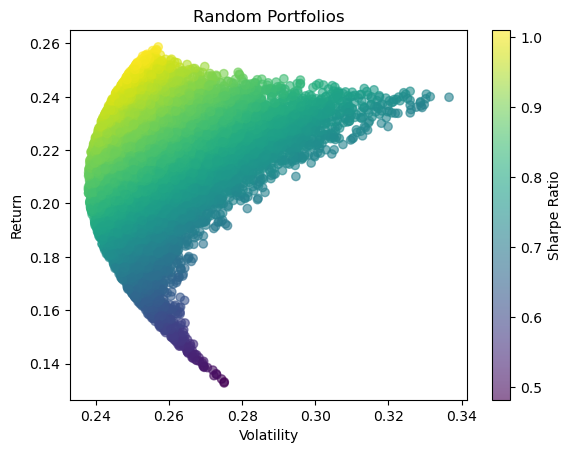

In [18]:
# Plot simulated portfolios (Efficient Frontier approximation) 
plt.scatter(results[0], results[1], c=results[2], cmap='viridis', alpha=0.6)
plt.xlabel('Volatility')
plt.ylabel('Return')
plt.colorbar(label='Sharpe Ratio')
plt.title('Random Portfolios')
plt.show()


In [21]:
from scipy.optimize import minimize

#  Define performance and objective functions 
def portfolio_perf(weights, mean_returns, cov_matrix):
    ret = np.dot(weights, mean_returns) * 252
    vol = np.sqrt(np.dot(weights.T, np.dot(cov_matrix * 252, weights)))
    return ret, vol

def neg_sharpe(weights, mean_returns, cov_matrix):
    ret, vol = portfolio_perf(weights, mean_returns, cov_matrix)
    return -ret / vol
    
# Set constraints: no short selling, weights sum to 1 
bounds = tuple((0, 1) for _ in range(n_assets))
constraints = {'type': 'eq', 'fun': lambda x: np.sum(x) - 1}
init_guess = np.ones(n_assets) / n_assets

# Optimize for maximum Sharpe ratio 
opt = minimize(neg_sharpe, init_guess, args=(mean_returns, cov_matrix),
               method='SLSQP', bounds=bounds, constraints=constraints)

opt_weights = opt.x
opt_return, opt_vol = portfolio_perf(opt_weights, mean_returns, cov_matrix)
opt_sharpe = opt_return / opt_vol


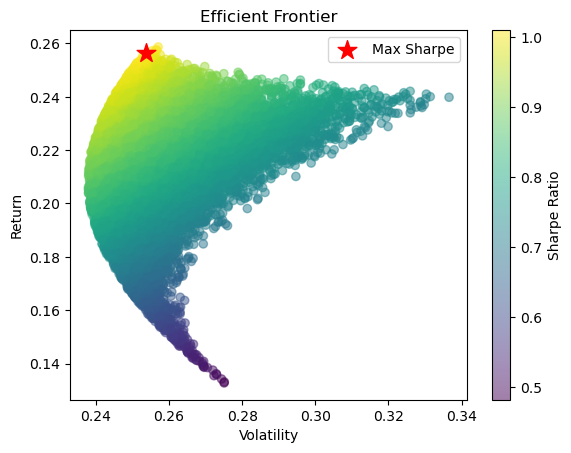

In [22]:
#  Plot optimized portfolio on top of the frontier 
plt.scatter(results[0], results[1], c=results[2], cmap='viridis', alpha=0.5)
plt.colorbar(label='Sharpe Ratio')
plt.scatter(opt_vol, opt_return, c='red', marker='*', s=200, label='Max Sharpe')
plt.xlabel('Volatility'); plt.ylabel('Return'); plt.title('Efficient Frontier')
plt.legend(); plt.show()


In [23]:
pd.Series(opt_weights, index=tickers).sort_values(ascending=False)


AMZN     8.918888e-01
GOOGL    1.081112e-01
MSFT     3.469447e-17
AAPL     0.000000e+00
dtype: float64